# Stephen Grivers  SCI378  Crichton Final Analysis 2020-04-17

In [52]:
from sci378 import *
import gzip
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from os import path

In [53]:
def set_plot_defaults():
    '''This is a redundant, workaround function.
    
       Although these defaults were imported from the SCI378.py file, sometimes
       they do not work for me unless I run them again every time I plot something.'''
    fontsize=20

    rcParams['font.size']=fontsize
    rcParams['font.family']='sans-serif'

    rcParams['axes.labelsize']=fontsize
    rcParams['axes.titlesize']=fontsize
    rcParams['xtick.labelsize']=fontsize
    rcParams['ytick.labelsize']=fontsize
    rcParams['legend.fontsize']=fontsize

    rcParams['figure.figsize']=(12,8)

    rcParams['axes.grid']=True

## Crichton's Primary Claim 

In Michael Crichton's book, the character Jennifer claims that while densely populated cities are warming over time, rural/smaller cities are cooling over time, contrary to a "global" warming idea. 

Even cities very close to each other experience this effect, such as the warming of New York, NY and the cooling of Syracuse, Albany, and Oswego, NY.  

**Crichton's primary claim is that Urban areas heat up more than Rural areas.**

# Verifying Crichton's Methods

The first step in making a decision on whether Crichton's claims are accurate is trying to reproduce his work.  This is done to first check if he made any errors, before evaluating the accuracy of his claim.

## Reproducing the Berkeley Plot

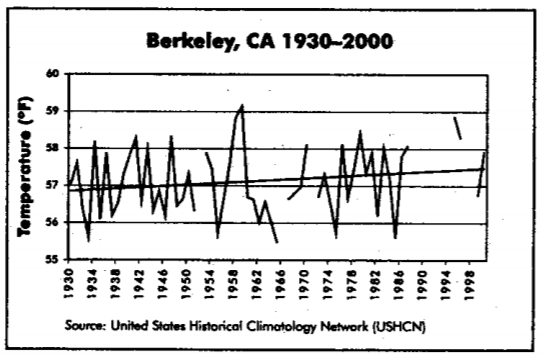

In [54]:
from IPython.display import Image
image = 'data/berkeley.PNG'
Image(filename=image)

In [55]:
dfberkeley = pd.read_csv('data/berkeley.csv')
dfberkeley.drop(dfberkeley[dfberkeley['metANN'] == 999.90].index, inplace=True) # <---- Drops null values of 999.90
dfberkeley['metANN'] = (dfberkeley['metANN'] * 9/5) + 32   # <------ Converts Celsius to Fahrenheit to match Crichton

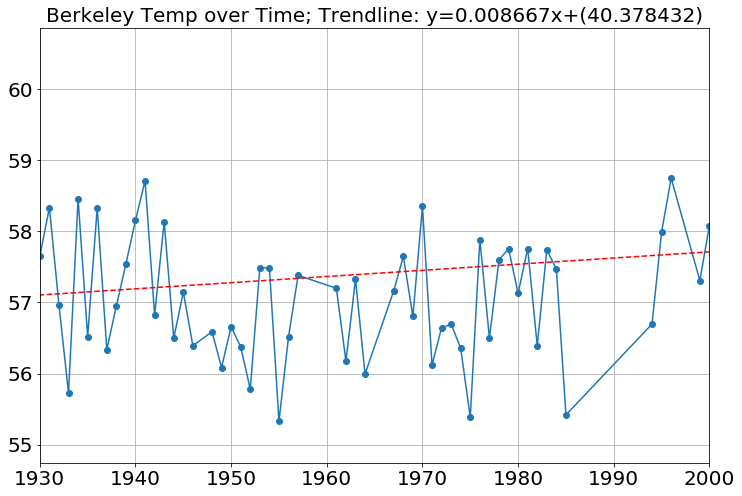

In [56]:
plt_title = 'Berkeley Temp over Time'
z = np.polyfit(dfberkeley['YEAR'], dfberkeley['metANN'], 1)
p = np.poly1d(z)
equation = 'y=%.6fx+(%.6f)' %(z[0],z[1])
plt.title(f'{plt_title}; Trendline: {equation}')
plt.xlim(1930, 2000)     # <---- matches Crichton's use of 1930-2000
plt.plot(dfberkeley['YEAR'],dfberkeley['metANN'],'-o')

plt.plot(dfberkeley['YEAR'],p(dfberkeley['YEAR']),"r--")

While there are a few slight discrepancies, such as the trendline beginning at a temperature less than 57 in Crichton's plot, and higher than 57 in my plot, a major jump in 1958 in Crichton's plot that is missing from my plot, and matplotlib's plot function not having the same gaps for missing years, my reproduced plot is similar enough to assert that Crichton did not make any technical errors in his analysis.

Now the question is whether or not he cherry picked the locations he used to back up his claim.

# Reading in the Data and Saving It

To find out whether or not Crichton cherry picked data to back up his claim, we must greatly expand the amount of data we use.  Even though Crichton only used U.S. cities, NASA's website only provides a dataset for all of their locations in the world.  However, if Crichton's claims are correct, then they should also be correct across the whole planet.  Download the data using this link: https://data.giss.nasa.gov/gistemp/station_data_v4_globe/v4.mean_GISS_homogenized.txt.gz .  The get_data function will turn this compressed .txt file into usable .csv files for analysis.

In [57]:
def get_data():
    '''This function reads in data downloaded from the NASA GISS website.  The compressed .txt file can be 
        downloaded using this link:
        https://data.giss.nasa.gov/gistemp/station_data_v4_globe/v4.mean_GISS_homogenized.txt.gz .
        It then converts the data to two pandas dataframes and saves them as compressed .csv files'''
    
    subset_station_lines=station_lines=open('data/station_list.txt').readlines()
    all_station_lines=open('data/v4.temperature.inv.txt').readlines()

    with gzip.open('data/v4.mean_GISS_homogenized.txt.gz','rt') as fid:
        GISS_lines=fid.readlines()
        
    time_arr=np.arange(1880,2021)
    temperature_arr=np.nan*np.ones(len(time_arr))

    data={'time':time_arr}
    info=Struct({'ID':[],
          'Station':[],
          'Latitude':[],
          'Longitude':[],
          'Brightness':[],
          'Elevation':[],
         })


    station_data=None

    count=0
    print("Starting...",end="")
    for line in GISS_lines:

        # do all the IDs start with A?
        if not line[0] in '12': # this is a header line, not starting with a 1 or a 2

            if not station_data is None:   #save the old station
                data[station_data.station]=temperature_arr
                temperature_arr=np.nan*np.ones(len(time_arr))

                info.ID.append(station_data.ID)
                info.Station.append(station_data.station)
                info.Latitude.append(station_data.lat)
                info.Longitude.append(station_data.long)
                info.Elevation.append(station_data.elev)
                info.Brightness.append(station_data.brightness)

                count+=1
                if count%100==0:
                    print(".",end="")
                if count%1000==0:
                    print("O",end="")

            station_data=Struct()

            header=line.split()
            #print(header)
            station_data.ID=header[0]
            station_data.lat=float(header[1])
            station_data.long=float(header[2])
            station_data.elev=float(header[3])

            if station_data.elev==9999.0:
                station_data.elev=np.nan


            station_data.station=header[4]

            if header[5]=='*':
                station_data.brightness=np.nan
            else:
                station_data.brightness=int(header[5])

            assert (len(header)==6) or ((len(header)==7) and (header[5]=='*'))
        else:  # this is a line of data
            parts=line.split()
            year=int(parts[0])

            raw_temp=[int(part) for part in parts[1:]]

            T=[]
            for i,raw_T in enumerate(raw_temp):
                time=year+i/12  # change the month into a real number

                if raw_T==-9999:
                    T.append(np.nan)
                else:
                    T.append(raw_T/100)




            idx=np.where(time_arr==year)[0][0]
            temperature_arr[idx]=np.nanmean(T)


    data[station_data.station]=temperature_arr

    info.ID.append(station_data.ID)
    info.Station.append(station_data.station)
    info.Latitude.append(station_data.lat)
    info.Longitude.append(station_data.long)
    info.Elevation.append(station_data.elev)
    info.Brightness.append(station_data.brightness)



    print("done.")
    
    info=pd.DataFrame(info)
    data=pd.DataFrame(data)
    
    info.to_csv("data/station_temperature_info.csv.gz", compression='gzip')
    data.to_csv("data/station_temperature_data.csv.gz", compression='gzip')

In [58]:
data_path = 'data/station_temperature_data.csv.gz'  
info_path = 'data/station_temperature_info.csv.gz'
if path.exists(data_path) and path.exists(info_path):
    print('You already have the data, no need to get it again!')
else:
    get_data()

You already have the data, no need to get it again!


Note: Once you have the data, you do not need to run this section again.

# Regression Analysis

Performing a regression analysis on the entire world will help to prove Crichton's claims to be accurate or inaccurate.

## Berkeley from Full Data Set 

First, lets perform it just on Berkeley again to verify Nasa's two data sources for Berkeley and make sure everything works for a simplified version of the problem.

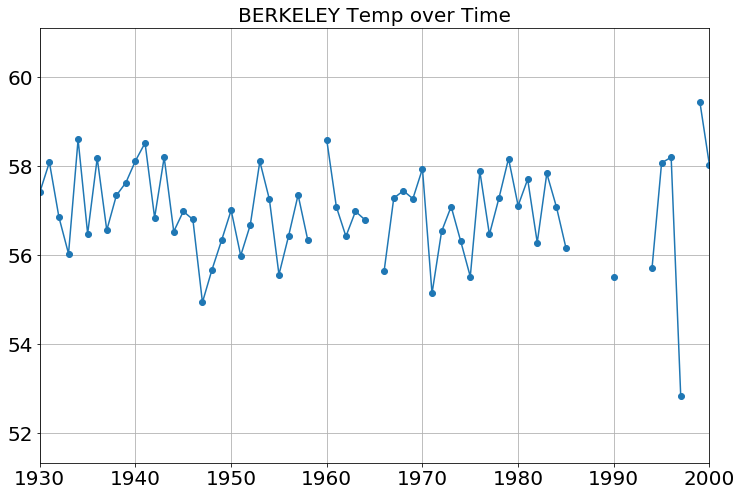

In [59]:
data=pd.read_csv('data/station_temperature_data.csv.gz',index_col=False)
info=pd.read_csv('data/station_temperature_info.csv.gz')

station='BERKELEY'
data[station] = (data[station] * 9/5) + 32   # <- Converts Celsius to Fahrenheit to match Crichton
data.drop(data[data[station] < 50].index, inplace=True) # <- Drops values not found in Berkeley data
x=data['time']
y=data[station]

plt.title(f'{station} Temp over Time')
plt.xlim(1930, 2000)     # <---- matches Crichton's use of 1930-2000
plt.plot(x,y,'-o')

In [60]:
def get_xy(data,station):
    x,y=array(data[['time',station]].dropna()).T    
    return x,y

x,y=get_xy(data,station)

model=ols('y ~ x', data={'y':y,'x':x})
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.562
Date:                Thu, 30 Apr 2020   Prob (F-statistic):             0.0615
Time:                        23:24:08   Log-Likelihood:                -202.48
No. Observations:                 123   AIC:                             409.0
Df Residuals:                     121   BIC:                             414.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.5131      5.645      8.239      0.000      35.336      57.690
x              0.0055      0.003      1.887      0.062      -0.000       0.011
==============================================================================
Omnibus:                       39.567   Durbin-Watson:                   1.459
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.272
Skew:                          -1.178   Prob(JB):                     2.53e-25
Kurtosis:                       7.068   Cond. No.                     9.65e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

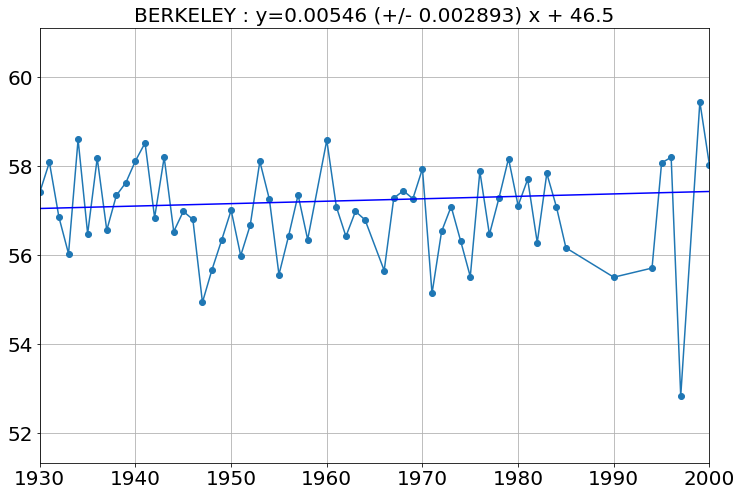

In [61]:
xx=np.linspace(min(x)-10,max(x)+10,20)
yy=results.predict({'x':xx})

m=results.params['x']
mσ=results.bse['x']

b=results.params['Intercept']

plt.plot(x,y,'-o')
plt.title(station+" : y=%.3g (+/- %.4g) x + %.3g" % (m,mσ,b))
plt.xlim(1930, 2000)     # <---- matches Crichton's use of 1930-2000
plt.plot(xx,yy,'b-')

Once again, there are a few discrepancies, but it is close enough to assert that each station in the full world dataset matches each station's individual dataset.  The trendline has a slightly different equation based on the OLS regression rather than the np.polyfit regression, and the data discrepancies, but it is generally the same, starting above the y-value of 57 and ending below the y-value of 58.

## Full Data Set

Now, run a regression on all stations.

Text(0.5, 1.0, 'All Stations')

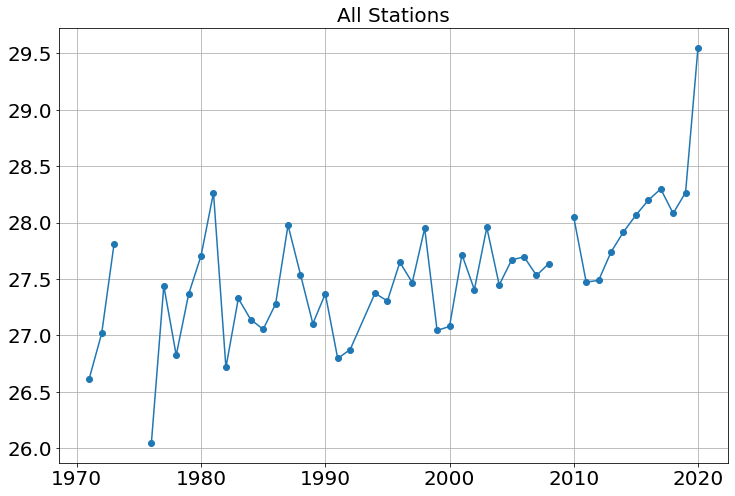

In [62]:
station = 'SAVE'
x=data['time']
y=data[station]
plt.plot(x,y,'-o')
plt.title('All Stations')

In [63]:
def get_xy(data,station):
    x,y=array(data[['time',station]].dropna()).T    
    return x,y

x,y=get_xy(data,station)

model=ols('y ~ x', data={'y':y,'x':x})
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     28.58
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           3.05e-06
Time:                        23:24:09   Log-Likelihood:                -27.547
No. Observations:                  46   AIC:                             59.09
Df Residuals:                      44   BIC:                             62.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -22.2444      9.311     -2.389      0.021     -41.009      -3.480
x              0.0249      0.005      5.346      0.000       0.016       0.034
==============================================================================
Omnibus:                       11.099   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.727
Skew:                           0.907   Prob(JB):                      0.00284
Kurtosis:                       4.681   Cond. No.                     2.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Discussion of P-values: Statistical Meaning

The 'P>|t|' values, or 'P-values' of this model are 0.021 for the Intercept, and 0.000 (less than 0.001) for the x.  P-values for variables in a regression model are the chance that the variable has no relationship/correlation with the dependent variable.  If a P-value of a variable is low (usually the consensus limit is 0.05), then it is a strong predictor of the target variable, and is considered statistically significant.  Both components of this model are statistically significant.

## Plotting the Regression

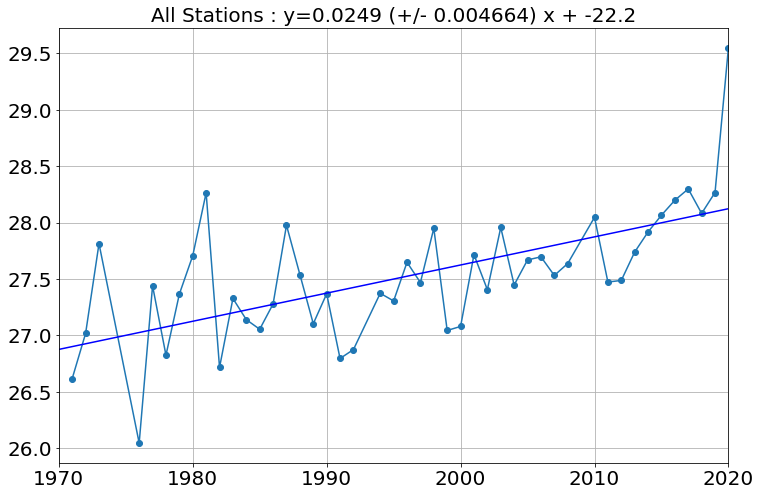

In [64]:
xx=np.linspace(min(x)-10,max(x)+10,20)
yy=results.predict({'x':xx})

m=results.params['x']
mσ=results.bse['x']

b=results.params['Intercept']

plt.plot(x,y,'-o')
plt.title('All Stations'+" : y=%.3g (+/- %.4g) x + %.3g" % (m,mσ,b))
plt.xlim(1970, 2020)     # <---- matches Crichton's use of 1930-2000
plt.plot(xx,yy,'b-')

There is a clear upward trend in temperature for all stations.  Now we must find out if this is due to urban cities, as Crichton claims.

# Analysis of Brightness 

**Brightness** is a metric provided by the NASA GISS website that 'classifies stations as Rural or Suburban'.  The greater the Brightness, the more Urban a station is.  For example, New York City's Central Park Tower has a Brightness of **146**, and Syracuse has a Brightness of **14**.  Brightness is listed in the **info** DataFrame.

In [65]:
#Warning: This will take a few minutes to run!
station_names=data.columns[2:]
S=Storage()
for station in station_names:
    #brightness=float(info[info['Station']==station]['Brightness'])
    brightness=array(info[info['Station']==station]['Brightness'])[0]
    x,y=get_xy(data,station)
    
    if len(x)==0:
        continue 
        
    model=ols('y ~ x', data={'y':y,'x':x})
    results=model.fit()
    m=results.params['x']
    mσ=results.bse['x']
    
    S+=brightness,m,mσ
    print(station)
    
brightness,m,mσ = array(S)

SAVE
SHARJAH_INTER_AIRP
RAS_AL_KHAIMAH_INTE
DUBAI_INTL
ABU_DHABI_BATEEN_AIR
ABU_DHABI_INTL
AL_AIN_INTL
MAZAR_I_SHARIF
HERAT
KABUL_INTL
KANDAHAR_AIRPORT
ALGER_DAR_EL_BEIDA
EL_GOLEA
IN_AMENAS
TAMANRASSET
ANNABA_CAP_DE_GARDE
ALGIERS_VILLE_UNIVERSITE
ALGIERS_CAP_CAXINE
FORT_NATIONAL
BEJAIA_BOUGIE_PORT
CONSTANTINE
ORLEANSVILLE_CHLEF
SETIF
TEBESSA
BISKRA
LAGHOUAT
GERYVILLE_EL_BAYADH
JIJEL
JIJEL_PORT
ANNABA
EL_KALA
SOUMMAM
GUELMA
TENES
AIN_BESSAM
MOHAMED_BOUDIAF_INTL
OUM_EL_BOUAGHI
SOUK_AHRAS
ECH_CHELIFF
MILIANA
MEDEA
BORDJ_BOU_ARRERIDJ
SETIF_AIN_ARNAT
ARZEW
MOSTAGANEM
ORAN_PORT
M'SILA
CHEIKH_LARBI_TEBESSI
KHENCHELLA
ES_SENIA
MASCARA_MATEMORE
GHRISS
BOU_CHEKIF
KSAR_CHELLALA
BOU_SAADA
BENI_SAF
MAGHNIA
ZENATA
DJELFA_TLETSI
SAIDA
EL_KHEITER
MECHERIA
EL_BAYADH
SIDI_MAHDI
NAAMA
GUEMAR
AIN_SEFRA
NOUMERAT
BECHAR
OUARGLA
OUED_IRARA
BENI_ABBES
TIMIMOUN
TOUAT_CHEIKH_SIDI_MOHAMED_BEL
IN_SALAH
ILLIZI_TAKHAMALT
TINDOUF
TISKA
BORDJ_BADJ_MOKHTAR
ADRAR
TOUGGOURT
HASSI_MESSOUD
EL_OUED
BENI_SAF_ALGERIA
GHARDAI

PARAWA_SECOND_VALLEY_FOREST_A
MOUNT_CRAWFORD_MT_CRAWFORD_AW
KUITPO_FOREST_RESERVE
BERRI_IRRIGATION
RENMARK
LOXTON_RESEARCH_CENTRE
WAIKERIE_GOLDEN_HEIGHTS
RENMARK_AERO
EUDUNDA
MENINGIE
MURRAY_BRIDGE_COMPARISON
TAILEM_BEND
STRATHALBYN_RACECOURSE
CALIPH
KEITH
LAMEROO_COMPARISON
CAPE_NORTHUMBERLAND
KYBYBOLITE_RESEARCH_CENTRE
LUCINDALE_POST_OFFICE
MOUNT_BURR_FOREST_RESERVE
MOUNT_GAMBIER_POST_OFFICE
MOUNT_GAMBIER_AERO
NARACOORTE
ROBE_COMPARISON
COONAWARRA
PADTHAWAY
CAPE_JAFFA_THE_LIMESTONE
NARACOORTE_AERODROME
PADTHAWAY_SOUTH
COEN_POST_OFFICE
COEN_AIRPORT_EVAP
MORETON_TELEGRAPH_STATION
THURSDAY_ISLAND_MO
WEIPA_EASTERN_AVE
WEIPA_AERO
HORN_ISLAND
COEN_AIRPORT
PALMERVILLE
MUSGRAVE
LOCKHART_RIVER_AIRPORT
BURKETOWN_POST_OFFICE
CLONCURRY_AERO
CROYDON_TOWNSHIP
JULIA_CREEK_POST_OFFICE
KOWANYAMA_AIRPORT
MORNINGTON_ISLAND
NORMANTON_POST_OFFICE
MOUNT_ISA_MINE
MOUNT_ISA_AERO
CLONCURRY_AIRPORT
HUGHENDEN_POST_OFFICE
MOUNT_SURPRISE_TOWNSHIP
RICHMOND_POST_OFFICE
CAIRNS_POST_OFFICE
CAIRNS_AERO
COOKTOWN_POST_

CRAIGIE_BONDI_FOREST_LODGE
BOMBALA_AWS
GOULBURN_AIRPORT_AWS
TUGGERANONG_ISABELLA_PLAINS
CHARLOTTE_PASS_KOSCIUSKO_CHAL
KIANDRA_CHALET
THREDBO_AWS
THREDBO_VILLAGE
ADELONG_POST_OFFICE
BROOKFIELD_FOREST_STATION
CARABOST_FOREST_HEADQUARTERS
HUME_RESERVOIR
TUMBARUMBA_POST_OFFICE
RED_HILL_STATE_FOREST
KHANCOBAN_SMHEA
CABRAMURRA_SMHEA
ALBURY_AIRPORT
WAGGA_WAGGA_AMO
WAGGA_WAGGA_KOORINGAL
ALBURY_AIRPORT_AWS
CABRAMURRA_SMHEA_AWS
KHANCOBAN_AWS
BURRINJUCK_DAM
COOTAMUNDRA_POST_OFFICE
GRENFELL_QUONDONG_RD
JUNEE_TREATMENT_WORKS
QUANDIALLA_POST_OFFICE
TEMORA_RESEARCH_STATION
WYALONG_POST_OFFICE
YOUNG_POST_OFFICE
COOTAMUNDRA_AERO
WAGGA_WAGGA_AGRICULTURAL_INSTI
YOUNG_AIRPORT
GUNDAGAI_WILLIAM_ST
COOTAMUNDRA_AIRPORT
BERRIGAN_POST_OFFICE
COROWA_AIRPORT
YANCO_AGRICULTURAL_INSTITUTE
DENILIQUIN_FALKINER_MEMORIAL
LEETON_CARAVAN_PARK
MATHOURA_STATE_FOREST
TOCUMWAL_AIRPORT
URANA_POST_OFFICE
WAGGA_WAGGA_RESEARCH_CENTRE
DENILIQUIN_WILKINSON_ST
NARRANDERA_AIRPORT
NARRANDERA_GOLF_CLUB
DENILIQUIN_AIRPORT_AWS
GRIFFITH_

ROBORE_CIV_MIL
JUANA_AZURDUY_DE_PADILLA
TTE_DE_AV_SALVADOR_OGAYA_G
CAPITAN_NICOLAS_ROJAS
CAMIRI
TCNL_RAFAEL_PABON
SANTA_CRUZ
LA_PAZ
ORURO
SICASICA
SUCRE
SANTA_ANA
LA_ANGOSTURA
MAGADALENA
MYITKYINA
MANDALAY
SITTWE
YANGON_INTL
MERGUI
VICTORIA_POINT
TAVOY
DIAMOND_ISLAND
BHAMO
AKYAB
RANGOON
KANDI
NATITINGOU
TCHAOUROU
PARAKOU
BOHICON
VERHNEDVINSK
YEZERISHCHE
SHARCOVSCHINA
LYNTUPY
POLOTSK
DOKSHITSY
LEPEL
VITEBSK
SENNO
BALTIJSK
ZHELEZNODOROZHNYJ
OSMJANY
VILEYKA
BORISOV
ORSHA
GORKI
GRODNO
LIDA
NOVOGRUDOK
MINSK
BEREZINO
MARIYNA_GORKA
MOGILEV
KLICHEV
SLAVGOROD
KOSTUCKOVICHI
VOLKOVYSK
PRUZANY
IVACEVICI
BARANOVICHI
GANEVICI
OKTYABR
SLUTSK
BOBRUISK
ZHLOBIN
VYSOKOJE
BREST
POLESKAYA
PINSK
ZHITCKOVICHI
MOZYR
VASILEVICI
GOMEL
LELOIOV
BRAGIN
MUNDA
GUADALCANAL_AAF
TULAGI
AUKI
HONIARA_BRITISH_SOLOMONS
FERNANDO_DE_NORONHA
CRUZEIRO_DO_SUL
CONCEICAO_DO_ARAGUAIA
CUIABA
RIO_DE_JANEIRO
PORTO_DE_MOZ
CAMETA
SANTAREM_AEROPORTO
ALTO_PARNAIBA
ALTA_FLORESTA_AERO
CIPO
JACOBINA
JOAO_PINHEIRO
PARACATU
AIMORES
CONCEICAO_

KELOWNA_PC_BURNETTS_NURSERY
KELOWNA_MWS0
KEREMEOS
KEREMEOS_2
MCCULLOCH
MERRITT
MERRITT_STP
NARAMATA
NICOLA_LAKE
OKANAGAN_CENTRE
OLIVER
OLIVER_STP
OSOYOOS
OSOYOOS_CS
OSOYOOS_WEST
OYAMA
PEACHLAND
PEACHLAND_BRENDA_MINES
PENTICTON
PENTICTON_A
PRINCETON_A
SIMILKAMEEN_MINE
SUMMERLAND_CDA
VERNON
VERNON_BELLA_VISTA
VERNON_COLDSTREAM_RANCH
VERNON_NORTH
WINFIELD
WOODS_LAKE
PRINCETON_CS
SUMMERLAND_CS
BEAVERDELL_NORTH
CARMI
GRAND_FORKS
GRAND_FORKS_RAYFIELD
GREENWOOD
MIDWAY
ROCK_CREEK
BILLINGS
BOSWELL
CASTLEGAR_A
CASTLEGAR_BCHPA_DAM
COLUMBIA_GARDENS
CRAWFORD_BAY
CRESCENT_VALLEY
CRESTON
CRESTON_WPCC
DEER_PARK
DUNCAN_LAKE_DAM
FAUQUIER
KASLO
LISTER
NAKUSP_CS
NAKUSP
NELSON
NELSON_NE
NELSON_2
NEW_DENVER
OLD_GLORY_MOUNTAIN
NELSON_CS
PERRY_SIDING
ROSSLAND_CITY_YARD
ROSSLAND_MACLEAN
SOUTH_SLOCAN
WANETA
WARFIELD
CRESTON_CAMPBELL_SCIENTIFIC
NELSON_RIXEN_CREEK
ABERFELDIE
BAYNES_LAKE_KOOTENAY_RIVER
CANAL_FLATS_RANGER_STN
CORBIN
CRANBROOK
CRANBROOK_A
ELKO
FERNIE
FORDING_RIVER_COMINCO
CRANBROOK_CITY
FT_STEELE_DA

NOKOMIS
ORMISTON
OXBOW
PARKERVIEW
PASWEGIN
PENSE
QU'APPELLE
QU'APPELLE_1
RAYMORE
REGINA_INT'L_A
REGINA_CDA
REGINA_CITY_GREENHOUSES
REGINA_RCS
ROCANVILLE
SALTCOATS
SEMANS
STRASBOURG
TUGASKE
WAPELLA_NEWFINLAND
WATROUS
WATROUS_EAST
WEYBURN
WHITEWOOD
WILCOX
WISHART
WYNYARD
YELLOW_GRASS
YORKTON_A
TONKIN
YORKTON
WYNYARD_AUT
REGINA_UNIVERSITY
ABBEY
ALSASK_HARDENE
ANEROID
ASSINIBOIA
ASSINIBOIA_AIRPORT
BEECHY
CADILLAC
CHAPLIN
CODERRE
COURVAL
CYPRESS_HILLS
EASTLEIGH
ELBOW_CS
ELBOW
ELBOW_2_NE
ELROSE
ESTON
GARDEN_HEAD
GOLDEN_PRAIRIE
GRAVELBOURG
GULL_LAKE_CDA_EPF
HERBERT_2
HUGHTON
INGEBRIGHT_LAKE
INSTOW
KINCAID
KLINTONEL
LEADER
LEADER_2
LUCKY_LAKE
MAPLE_CREEK
MAPLE_CREEK_NORTH
PENNANT
READLYN
ROADENE
ROCK_POINT
SHAMROCK
SHAUNAVON
SHAUNAVON_2
STEWART_VALLEY
SURPRISE
SWIFT_CURRENT
SWIFT_CURRENT_A
SWIFT_CURRENT_CDA
LEADER_AIRPORT
CLAYDON
CORONACH
CORONACH_SPC
CYPRESS_HILLS_PARK
EASTEND_CYPRESS_AUT
FRONTIER
MANKOTA
MINTON
NASHLYN
ROCKGLEN_AUT
TREELON
VAL_MARIE
VAL_MARIE_SOUTHEAST
WEST_POPLAR_RIVER
WILL

GEORGETOWN_WWTP
HAMILTON_A
HAMILTON_MUNICIPAL_LAB
HAMILTON_PSYCH_HOSPITAL
HAMILTON_RBG
HAMILTON_RBG_CS
JANETVILLE
KING_SMOKE_TREE
LAKEVIEW_MOE
MILLGROVE
OAK_RIDGES
OAKVILLE
ORANGEVILLE_MOE
ORONO
OSHAWA_WPCP
PICKERING_AUDLEY
PICTON
POINT_PETRE_AUT
RICHMOND_HILL
RICHMOND_HILL_WPCP
SMITHFIELD_CDA
STONEY_CREEK
STOUFFVILLE_WPCP
TORONTO
TORONTO_CITY
TORONTO_AGINCOURT
TORONTO_DOWNSVIEW_A
TORONTO_ELLESMERE
TORONTO_ISLAND_A
TORONTO_ISLINGTON
TORONTO_LESTER_B_PEARSON_INT
TORONTO_MET_RES_STN
TORONTO_WILSON_HEIGHTS
TRENTON_A
TRENTON_MOE
TWEED
TYRONE
UXBRIDGE
UXBRIDGE_2
MOUNTAINVIEW
TORONTO_BUTTONVILLE_A
OAKVILLE_SOUTHEAST_WPCP
TORONTO_NORTH_YORK
APSLEY
BANCROFT
HALIBURTON_A
HALIBURTON_3
KINMOUNT
LAKEFIELD
LINDSAY
LINDSAY_FILTRATION_PLANT
LINDSAY_FROST
LORNEVILLE
MINDEN
NORWOOD
PETERBOROUGH
PETERBOROUGH_A
PETERBOROUGH_DOBBIN_TS
PETERBOROUGH_STP
QUEENSBORO
BANCROFT_AUTO
BERTHIERVILLE
CHUTE_PANET
COTEAU_DU_LAC
DESCHAMBAULT
DONNACONA_2
DUCHESNAY
JOLIETTE
JOLIETTE_VILLE
L'ASSOMPTION
LAVALTRIE_CDA
LES_C

UPPER_STEWIACKE
WATERVILLE_CAMBRIDGE
WESTERN_HEAD
WESTPHAL
WEYMOUTH_FALLS
WHITEHEAD
WINDSOR_FALMOUTH
WINDSOR_KINGS_COLLEGE
WINDSOR_MARTOCK
WOLFVILLE
WRECK_COVE_BROOK
YARMOUTH
YARMOUTH_RCS
YARMOUTH_A
ALLISTON
CHARLOTTETOWN
CHARLOTTETOWN_A
CHARLOTTETOWN_CDA
EAST_BALTIC
EAST_POINT_AUT
ELMWOOD
LONG_RIVER
O'LEARY
STANHOPE
SUMMERSIDE
SUMMERSIDE_CDA
SUMMERSIDE_A
TIGNISH
HARRINGTON_CDA_CS
ARGENTIA_A
ARGENTIA_AUT
ARNOLDS_COVE
BAIE_VERTE
BAY_D'ESPOIR_GEN_STN
BLACK_DUCK
BOAT_HARBOUR
BOTWOOD
BRANCH
BUCHANS
BUCHANS_A
BURGEO
BURGEO_2
BURGEO_NL
BURNT_POND
CAPE_RACE_AUT
CARMANVILLE
CHANNEL
CHARLESTON
CLARENVILLE
COLINET
COME_BY_CHANCE
COMFORT_COVE
CORMACK
CORNER_BROOK
COW_HEAD
DANIELS_HARBOUR
DEER_LAKE
DEER_LAKE_A
ENGLEE_AUT
EXPLOITS_DAM
FEROLLE_POINT_AUT
FLOWERS_COVE
GALLANTS
GANDER_INT'L_A
GANDER_INTL_A
GANDER_AIRPORT_CS
GLENWOOD
GOOBIES
DOYLES
GRAND_BANK
HARBOUR_BRETON
HAWKE'S_BAY
HEARTS_CONTENT
HOLYROOD_GEN_STN
INDIAN_BAY_BB
ISLE_AUX_MORTS
LA_SCIE
LOGY_BAY
LONG_HARBOUR
MIDDLE_ARM
MUSGRAVE_HARBOUR


COTOPAXI
IBARRA
GUYAQUIL_SIMON_BOLIV
QUITO_M_SUCRE
BANOS
CUENCA
MERSA_MATRUH
ASSWAN
SIWA
HURGUADA
BAHARIA
SALLOUM
PORT_SAID
CAIRO_ABBASSIA
CAIRO_EZBEKIYA
GIZA_CAIRO
HELWAN_CAIRO
EL_SUEZ
SALLUM_PLATEAU
ALEXANDRIA_INTL
EL_ARISH_INTL
CAIRO_A
HELWAN
MINYA
ASYOUT
LUXOR
KHARGA
TOR
KOM_EL_NADURA
CAIROEGYPCAIR
VALENTIA_OBSERVATORY
BIRR
DUBLIN_PHOENIX_PARK
MALIN_HEAD
BALLYHAISE_AGRCOLL
BELLACORRICK_MONEYNIERIN
BOORA
DERRYGREENAGH
DUNDALK_ANNASKEAGH_WW
GLENAMOY
GLENGARRIFF_ILNACULLIN
GLENTIES_HATCHERY
KELLS_HEADFORT
MARKREE_CASTLE
TRALEE_CLASH
WARRENSTOWN
GURTEEN
GALWAY
WATERFORD_TYCOR
BALLYSHANNON_CATHLEENS_FALL
ROCHES_POINT
CORK
JOHNSTOWN_CASTLE
ROSSLARE
CASEMENT
CLAREMORRIS
MULLINGAR
CONNAUGHT
BELMULLET
KILKENNY
TALLINN
KUNDA
RISTNA
LAANE_NIGULA
VIRTSU
KUUSIKU
TURI
VALKE_MAARJA
VILJANDI
KURESSAARE_ROOMASSAA
KIHNU
AINAZI
PJARNU
TARTU
VORU
VILSANDI
TARTU_TORAVERE
ASMARA
MASSAWA
ASSAB
ACAJUTLA
SAN_SALVADOR_ILOPAN
SAN_SALVADOR
LOS_ANDES
GONDAR
BAHAR_DAR
COMBOLCHA
DEBREMARCOS
JIMMA
ADDIS_ABABA_BOL

HAMBURG_FUHLSBUETTEL
EMDEN_HAFEN
LINDENBERG
HOHENPEISSENBERG
LAHR_A_GERMANY
DONAUESCHINGEN
DORTMUND
DRESDEN_HOSTERWITZ
BAD_DURKHEIM
DUISBURG_FRIEMERSHEIM
EBERBACH_NECKAR
EBERSBACH_FILS
EBERSBERG_HALBING
EBRACH
EIBERG
EICHSTATT_LANDERSHOFEN
EIMELDINGEN
EINBECK
EISLEBEN_HELFTA
ELLWANGEN_RINDELBACH
ELSDORF_ERFTKREIS
BAD_SOHL_ELSTER
ELZACH_FISNACHT
EMMENDINGEN_MUNDINGEN
BAD_EMS
ENGELSKIRCHEN
EPPINGEN
ERFDE
ERISKIRCH_MARIABRUNN
MOHRENDORF_KLEINSEEBACH
ESCHWEGE
ESENS
ESLOHE
WEILERSWIST_LOMMERSUM
EUTIN
ALTGLASHUTTE
KRROTTAL_INN_FALKENBERG
FELDBERG
FICHTELBERG_OBERFRANKEN_HUTTST
HAMELN_HASTENBECK
FLADUNGEN_HEUFURT
HELMSTEDT_EMMERSTEDT
FLENSBURG
FLOSSENBURG
FRANKFURT_MAIN_STADT
FRANKFURT_ODER
ALTOMUNSTER_MAISBRUNN
HERSDORF_WEISSENSEIFEN
FREIAMT_OTTOSCHWANDEN
FREIBURG_ELBE
FRIEDRICHSBRUNN
MALSBURG_MARZELL_FRIEDRICHSHEI
ALZEY
AMERANG_PFAFFING
AMMERLAND
TRAUNSTEIN_GEISSING
GELNHAUSEN
OHLSBACH
GERNRODE
GERNSHEIM_ALLMENDFELD
GILSERBERG_MOISCHEID
GLUCKSTADT
GOSSWEINSTEIN
ANNABERG_BUCHHOLZ
GRAFENBERG_

ATHINAI_OBSERVATORY
KALAMAIWAS_167240
GUATEMALA_CITY
LABE
SIGUIRI
BOKE
KINDIA
MAMOU
KANKAN
CONAKRY_AERO
MACENTA
N'ZEREKORE_KONIA
NICKERIE_SURINAM
COEROENI
PORT_AU_PRINCE_BOWEN_FLD_HAITI
PUERTO_LEMPIRA
CATACAMAS
TEGUCIGALPA
CHOLUTECA
GUANAJA
GOLOSON_INTL
LA_MESA_INTL
SANTA_ROSA_DE_COPAN
ZAGREB_GRIC
CRIKVENICA
METLIKA
GOSPIC
HVAR
LASTOVO
OSIJEK
RIJEKA
SPLIT_MARJAN
ZAVIZAN
KRAPINA
PORTOROZ
SISAK
ZADAR_ZEMUNIK
ZAGREB_PLESO
PULA
PECS_POGANY
BUDAPEST
GYOR
KECSKEMET
LENDAVA
MISKOLC
SOPRON
SZOMBATHELY_REPULOTER
PAPA
VESZPREM_SZENTKIRAL
BUDAPEST_PESTSZENTLORINC
KEKESTETO
SZOLNOK_ALCSISZIGET
DEBRECEN
NYIREGYHAZA_SOSTOGYOGYFU
SZENTGOTTHARD_FARKASFA
NAGYKANIZSA
SIOFOK_OBSZERVATORIUM
PAKS
BAJA_CSAVOLYI_UT
SZEGED_AUT
BEKESCSABA_FENYES
DEBRECENHUNGARY
PECS
MAGYAROVAR_HUNGARY
GUFUSKALAR
STYKKISHOLMUR
VESTMANNAEYJAR
AKUREYRI
TEIGARHORN
DALATANGI
HVERAVELLIR
KIRKJUBAEJARKLAUSTUR
GRIMSEY
RAUFARHOFN
HORNAFJORDUR
KEFLAVIK
BOLUNGAVIK
SIBOLGA_PINANGSORI
TAREMPA
PADANG_TABING
CILACAP
SANGKAPURA_BAWEAN
MENADOS

TALAS
BISHKEK
SUSAMYR
CATKAL_RIVER
TOKTOGUL_IN_KIRGIZ
DZHALAL_ABAD
OSH
KARA_SUU
GULCA
SARY_TAS
KAZARMAN
TYUYA_ASHU_SOUTHERN
ATBASHI
PRZHEVALSK
KOILYU
AKSAI
CHAAR_TASH
SANTASH
CHOLPON_ATA_KIRGIZ
ALAARCHA
CHONARYK
POKROVKA
CHATIRKUL
ALPLAGER
HAIDARKAN
TANGIVORUH
KOCHKORKA
ISFANA
DZHERGETAL
ANGREN
KIROVSKOE
USTIE_RTOS
GUL_CHA_KIRGIZ
KARAKUDZHUR
AKTASH_KYRG
VERHNIY_GORELNIK
ARPA
BAITYK
SENBONG
SAMJIYON
CHONGJIN
CHUNGGANG
HYESAN
KANGGYE
PUNGSAN
KIMCHAEK_SONGJIN
SUPUNG
CHANGJIN
SINUIJU
KUSONG
HUICHON
HAMHEUNG
ANJU
YANGDOK
WONSAN
PYONGYANG_INTL
NAMPO
CHANGJON
SARIWON
SINGYE
RYONGYON
HAEJU
KAESONG
PYONGGANG
UNGGI
CHANGBAI
PYONGYANG
TARAWA
ARORAE
MALDEN_ISLAND_AF
OCEAN_ISLAND
TARAWA_GILBERT_ISLA
BANABA
FANNING_ISLAND
INCHEON
ULLEUNGDO
MOKPO
CHUNCHEON
GANGNEUNG
SEOUL_CITY
TAEJON
POHANG
CHANGWON
KWANGJU
BUSAN
YEOSU
JEJU
SEOUL_ROK_K_14
TAEGU_ROK_K_2
KUNSAN
GOSAN
SONGSANP'O
SOSAN
CHONJU
CH'UNGJU
HAENAM
CHUNGMU
CHONGJU
CHOMCH'ON
SAMCH'OK
KOHUNG
ULSAN
POUN
KANGHWA
CHANGHUNG
SOKCHO
IMSHIL
KOCH'ANG
CHE

PRESA_VENUSTIANO_CAR
SAN_JACINTOTODOS_SAN
ESCARCEGA_ESCARCEGA
IXTLAHUACAN_DGE
SAN_BARTOLOME_AYAUTL
TUXTLA_GUTIERREZ
MATIAS_ROMERO_M_ROM
EL_REFUGIO_COMONDU
RAMOS_ARIZPESMN
PALOS_BLANCOS_CULIAC
LA_DURA_ROSARIO
SANTIAGOPAPASQUIARO
SAN_LUCAS_OJITLAN
IRAQUI_LA_PAZ
LA_UNION_CINTALAPA
ATOYAC_DE_ALVAREZ_SM
LA_TRINITARIA_ZAPALU
GUANACEVIGUANACEVISM
VALLE_NACIONAL_VALLE
LA_GRANDE_TEXCOCO
CALLEJONES_TECOMAN
EL_REFUGIO_MANTE_DGE
SAN_FELIPE_SAN_J_DE
LAS_CUEVAS_11
TEKAX_DE_ALVARO_OBRE
LABUFA
BACADEHUACHI_DGE
STODOMINGO_TEHUANTE
LAS_ENRAMADAS_NUEVO
EL_AGUILA_SONORA
SAN_IGNACIO_BAJA_CA
MASCOTA_JALISCO
HUICHAPAN_HUICHAPAN
SAN_JOSE_DEL_CABO
ABALA_ABALA
XOCNACEH_TICUL
GUADALAJARA_JALISCO
BUENAVISTA_CUAUHTEMO
SANTA_GERTRUDISTSAN
PUEBLA_PUE
AHUALULCO_GOMEZ_FARI
AGUA_BUENA_TAMASOPO
OSTUTA_SANTO_DOMINGO
SANTIAGO_IXCUINTLA
ATOYAC_ATOYACDGE
VICTORIA_VICTORIA
CUERNAVACA_MORELOS
HACIENDA_SANTA_ELENA
EJIDO_REATARAMOS_ARI
JOLALPAN_JOLALPAN_SM
EL_RODEO_MIACATLAN
CUAUHTEMOC_CHIHUAHU
GOMEZ_FARIAS_G_FARI
EL_TUITO_C_CO

KHUSHAB
PAD_IDAN
BANNU
SUKKUR
LASBELLA
CHAMAN
DERA_ISMAIL_K
NOSHKI
KAKUL
LAYALLPUR_FAISALABAD
KARACHI_MANORA
CHERAT
DERA_ISMAIL_KHAN
CHAKDARA
BADIN
BAHAWALPUR
QUETTASHEIKH_MANDA
WANA
LEBA
SIEDLCE
HEL
RZESZOW_JASIONKA
SWINOUJSCIE
OLSZTYN
SLUBICE
LESZNO
WIELUN
SULEJOW
RACIBORZ
BIELSKO_BIALA
NOWY_SACZ
LESKO
PULAWY
CHOJNICE
MLAWA
GORZOW_WLKP
KALISZ
KATOWICE
KIELCE
KOSZALIN
ELBLAG_MILEJEWO
SUWALKI
SZCZECIN
TORUN
BIALYSTOK
LAWICA
OKECIE
ZIELONA_GORA
STRACHOWICE
WLODAWA
KLODZKO
OPOLE
CZESTOCHOWA
BALICE
SANDOMIERZ
ZAMOSC
ZAKOPANE
PRZEMYSL
PL_POZNANPOSEN
PL_SKLARSKA_POREBASCHREIBERHA
LUBLIN_RADAWI
KETRZYN
OSTROLEKA
KOLOBRZEG
MIKOLAJKI
USTKA
TARNOW
LODZ
LEGNICA_BARTO
LEBORK
XRAXOW_POLANDWAS_125650
WROCLAW
KASPROWY_WIER
JELENIA_GORA
PLOCK
TERESPOL
KOLO
TAVIRA
HORTA_AZORES
FUNCHAL
LISBOA_GEOFISICA
PORTO
COIMBRA
BEJA
SANTAREM
PEGOES
ALVEGA
MORA
FLORES
PONTA_DELGADA
SANTA_MARIA
FUNCHAL_SCATARINA
PORTO_SANTO
CABO_CARVOEIRO
SAGRES
PORTO_PORTUGAL
COIMBRA_CERNACHE
FARO
EVORA_PORTUGAL
EVORA_C_COORD
PENHA

NAGORNYJ
TYNDA
TULUN
ZHIGALOVO
BARGUZINSKIJ_ZAPOVEDNIK
SOLNETHNAYA
TASSA
KARAFTIT
BAGDARIN
TROICKIJ_PRIISK
UST_KARENGA
ZIMA
BALAGANSK
KACUG
BAJANDAJ
BOLSHOJ_USHKANIJ_OSTROV
UST_BARGUZIN
BARGUZIN
ROMANOVKA
ZILOVO
MOGOCA
KSENEVSKAJA
GORBICA
EROFEJ_PAVLOVIC
IGNASINO
SKOVORODINO
DZALINDA
INGA
IRKUTSK
SUHAJA
BOLSHOE_GOLOUSTNOE
KABANSK
GORJACINSK
HORINSK
ZAMOKTA
SOSNOVO_OZERSKOE
CHITA
USUGLI
NERCINSK
UST_KARA
SRETENSK
URJUPINO
MONDY
TUNKA
HAMAR_DABAN
BABUSKIN
ULAN_UDE
TANHOJ
NOVOSELENGINSK
PETROVSKIJ_ZAVOD
MOGZON
HILOK
ULETY
KARYMSKAJA
SHILKA
NERCHINSKIJ_ZAVOD
CAKIR
KJAHTA
KRASNYJ_CHIKOJ
KYRA
MANGUT
AKSA
OLOVJANNAJA
BORZJA
ALEKSANDROVSKIJ_ZAV
PRIARGUNSK
KAJLASTUJ
ALDAN
TOMMOT
UCHUR
UST_JUDOMA
YUGARENOK
OHOTSK
TALON
KANKU
CJULBJU
TOKO
NELKAN
AJAN
BOLSOY_SANTAR
UNAHA
DZANA
BOMNAK
LOKSAK
UDSKOE
CUMIKAN
MAGDAGACI
ZEJA
OGORON
NORA
EKIMCHAN
SELEMDZA
BURUKAN
LITKE
NIKOLAEVSK_NA_AMURE
CHERNJAEVO
GAR
NORSK
BYSSA
IM_POLINY_OSIPENKO
VESELAJA_GORKA
GUGA
DZAORE
BOGORODSKOE
SIMANOVSK
MAZANOVO
SVOBODNYJ
VE

MORON_DE_LA_FRONTERA
SEVILLA_SAN_PABLO
SORIA
REUS_AEROPUERTO
CALAMOCHA
CALAMOCHA_VOR
TERUEL
TOLEDO
TOLEDO_LORENZANA
VALENCIA_AEROPUERTO
VALLADOLID
VALLADOLID_VILLANUBLA
BILBAO_AEROPUERTO
DAROCA
PALMA
GRANADAARMILLA
ROTA_NAS
TORREJON
SANTIAGO_COMPOSTELA
BILBAO
SEVILLA_TABLADA
BADAJOZ
MAHON_SAN_LUIS
WADI_HALFA
ABU_HAMED
PORT_SUDAN
DONGOLA
KHARTOUM
KASSALA
GEDAREF
EL_FASHER
SENNAR
GENINA
EL_OBEID
EN_NAHUD
NYALA
MALKAL
WAU
JUBA
KARIMA
TOKAR
ATBARA
SHENDI
HALFA_EL_GAIDIDA
ED_DUEIM
WAD_MEDANI
KOSTI_RABAK
ABU_NA'AMA
RENK
RASHAD
DAMAZIN
BABANUSA
KADUGLI
ZALINGEI
EL_OBEIDSUDAEL_O
WAU_SUDAN
ROSEIRES
DOLEIB_HILL
SUAKIN
GENEINASUDAGENE
GEBEIT
SINGA
TOZI_ABU_NAAMA_SUDAN
SVALBARD_AIRPORT
VIKTORIYA_ISLAND
BARENCBURG
KVIKKJOKK_ARRENJARKA
STENSELE
HAPARANDA
HOLMOGADD_A
HARNOSAND
MALUNG
SAVE_SKALVISERED
JONKOPINGS_FLYGPLATS
VISBY
LINKOEPING
FALUN
GUNNARN
KARLSTAD
SVENSKA_HOGARNA
NIDINGEN_A
HARSTENA_A
SKAGSUDDE_A
BJUROKLUBB_A
RINGHALS
VADEROBOD
SARNA
FALLFORS_MO
STORON_A
VAEXJOE
OESTERSUND
GOTEBORG_A
SAT

OGUZELI
ADIYAMAN
SANLIURFA
DIYARBAKIR
BATMAN
HAKKARI
MUGLA
ANTALYA
MERSIN
ISKENDERUN
INCIRLIK
ZILE
BODRUM
HINIS
DORTYOL
MALAZGIRT
IGDIR
BAFRA
CEMISGEZEK
KELES
YUMURTALIK
POZANTI
GAZIANTEP
ANKARA_ETIMES
PAZAR_RIZE
DIVRIGI
KOCAELI
SELCUK
ERCIS
DIKILI
SEBINKARAHISAR
GOKSUN
MESUDIYE
KEBAN
TUNCELI
ALPASLAN_DUC
ERGANI
GOKCEADA
ESKISEHIR
SIVEREK
KUMKOY
KARAISALI
HOZAT
ULUBORLU
ANTAKYA
AMASYA
KUSADASI
MURADIYE_VAN
KARAMAN
YALOVA
TORTUM
BURDUR
DINAR
TAHIROVA_T_A_C
CEYLANPINAR
SARIZ
KIRIKKALE
MANISA
DOGUBEYAZIT
BAKLABOSTAN
BOGAZLIYAN
YUKSEKOVA
BITLIS
KIZILCAHAMAM
AYVALIK
EMIRDAG
ANKARA_ESENBO
ODEMIS
BIRECIK
KANGAL
SIVRIHISAR
FETHIYE
KAMAN
ILGIN
BASKALE
HOPA
PINARBASI
DURSUNBEY
ACIPAYAM
ALANYA
SULTANHISAR
SARIYER
OZALP
BOLVADIN
AKSARAY
AKSEHIR
VAN_FERITMELEN
KOYCEGIZ
SALIHLI
DALAMAN
SEYDISEHIR
CICEKDAG_DUC
PALU
CUMRA
TEFENNI
SEFERIHISAR
TOSYA
KIRKLARELI
ARAPKIR
ANAMUR
SIMAV
KARAPINAR
CIZRE
BEYPAZARI
ISLAHIYE
ULUKISLA
AHLAT
TOMARZA
MILAS
KOZAN
DUZCE
MUSTAFAKEMALPAS
BORNOVA
ULUDAG_SARIALAN
GUNEY
KO

YUCCA_1_NNE
YUMA_CITRUS_STN
YUMA_DATE_ORCHARD
YUMA_VALLEY
ALICIA_2NNE
ALUM_FORK
AMITY_1N
ARKADELPHIA_2_N
ARKANSAS_POST
BATESVILLE_LVSTK
BATESVILLE_LD_1
BEE_BRANCH
BEEDEVILLE_4_NE
BENTONVILLE_4_S
BLAKELY_MTN_DAM
BLUE_MTN_DAM
BLYTHEVILLE
BOONEVILLE_3_W
BOONEVILLE_3_SSE
BRINKLEY
CABOT
CALICO_ROCK_2_WSW
CALION_LD
CAMDEN_1
CANE_CREEK_SP
CLARENDON
CLARKSVILLE_6_NE
CLARKSVILLE_2
CONWAY
CORNING
CROSSETT_2_SSE
DARDANELLE
DEER
DEQUEEN
DERMOTT_3_NE
DES_ARC
DEVILS_KNOB
DUMAS
EUDORA
EUREKA_SPRINGS_3_WNW
EVENING_SHADE_1_NNE
FAYETTEVILLE_EXP_STN
FORDYCE
FT_SMITH_WTP
FT_SMITH
GILBERT
GRANNIS
GRAVETTE
GREENBRIER
GREERS_FERRY_DAM
HARDY
HOPE_3_NE
HOT_SPRINGS_1_NNE
HUNTSVILLE_1_SSW
JONESBORO_2_NE
KEISER
KEO
LEAD_HILL
LEOLA
LITTLE_ROCK_ST_CAPITOL
MAGNOLIA
MAMMOTH_SPRING
MARIANNA_2_S
MARKED_TREE
MARSHALL
MENA
MOROBAY_LOCK
MORRILTON
MT_IDA_3_SE
MOUNTAINBURG_2_NE
MTN_HOME_1_NNW
MTN_HOME_C_OF_ENG
MTN_VIEW
MURFREESBORO_1W
NARROWS_DAM
NASHVILLE
NEWPORT
NIMROD_DAM
ODEN_1_SE
OKAY
OSCEOLA
OZARK
OZARK_2
PARAGOULD
PA

SPICER
SPRINGFIELD_7_WSW
STEAMBOAT_SPRINGS
STERLING
STRONTIA_SPRINGS_DAM
SUGARLOAF_RSVR
SUNBEAM_7_SW
TACONY_13_SE
TAYLOR_PARK
TELLURIDE_4WNW
TRINIDAD
TRINIDAD_LAKE
TWIN_LAKES_RESERVOIR
TWO_BUTTES
URAVAN
VAIL
VALLECITO_DAM
VICTOR
VIRGINIA_DALE_7_ENE
WAGON_WHEEL_GAP_3_N
WALDEN
WALSENBURG_1_NW
WALSH_1_W
WATERDALE
WESTCLIFFE
WHEAT_RIDGE_2
WILLIAMS_FORK_DAM
WOLF_CREEK_PASS_1_E
WRAY
YAMPA
YELLOW_JACKET_2_W
YUMA
BAKERSVILLE
BULLS_BRG_DAM
COLCHESTER_2_W
COVENTRY
CREAM_HILL
DANBURY
FALLS_VILLAGE
HAMPTON
MANSFIELD_HOLLOW_LAKE
MIDDLETOWN_4_W
MT_CARMEL
NEW_HAVEN
NEW_LONDON
NORFOLK_2_SW
NORWALK
NORWALK_GAS_PLT
NORWICH_PUB_UTILITY_PLANT
PUTNAM
SALISBURY
SHEPAUG_DAM
STAMFORD_5_N
STORRS
WATERBURY
WATERBURY_CITY_HALL
WESTBROOK
WEST_THOMPSON_LAKE
WIGWAM_RSVR
BRIDGEVILLE_1_NW
DELAWARE_CY_REEDY_POIN
GEORGETOWN_5_SW
GREENWOOD_2NE
LEWES
MIDDLETOWN_3_E
MILFORD_2_SE
MILLSBORO
NEWARK_UNIV_FARM
WILMINGTON_CITY_HALL
WILMINGTON_PORTER_RES
APALACHICOLAAIRPORT
ARCADIA
ARCHBOLD_BIO_STN
AVON_PARK_2_W
BARTOW
BELLE_GLA

KOKOMO_3_WSW
LAFAYETTE
LAFAYETTE_8_S
LAGRANGE
LAKEVILLE
LAPORTE
LOGANSPORT_CICOTT_ST
LOGANSPORT_RADIO_WSAL
LOWELL
MADISON_SEWAGE_PLT
MARION_2_N
MARKLAND_DAM_39
MARTINSVILLE_2_SW
MAUZY
MOORES_HILL
MT_VERNON
MUNCIE_4_SE
NEW_CASTLE_3_SW
NEW_HARMONY
NEW_WHITELAND
NORTH_VERNON_2_ESE
NORTHFIELD
OAKLANDON_GEIST_RSVR
OGDEN_DUNES
OOLITIC_PURDUE_EX_FRM
PAOLI
PERRYSVILLE_4_WNW
PLYMOUTH
PLYMOUTH_PWR_SUBSTN
PORTLAND_1_SW
PRAIRIE_HEIGHTS
PRINCETON_1_W
RENSSELAER
RICHMOND_WTR_WKS
ROCKVILLE
SAINT_MEINRAD
SALAMONIA
SCOTTSBURG
SEYMOUR_2_N
SHAKAMAK_SP
SHELBYVILLE_SEWAGE_PLT
SHOALS_8_S
SPURGEON
TELL_CITY
TERRE_HAUTE_INDIANA_ST
TIPTON_5_SW
VALPARAISO_WTR_WKS
VEEDERSBURG
VEVAY
VINCENNES_4_E
VINCENNES_5_NE
WABASH
WANATAH_2_WNW
WARSAW
WASHINGTON_1_W
WATERLOO_2_NW
WEST_LAFAYETTE_6_NW
WHEATFIELD
WHITESTOWN
WHITING
WINAMAC_2SSE
WINCHESTER_AIRPORT_3_E
WINONA_LAKE
WORTHINGTON
YOUNG_AMERICA
ALBIA_3_NNE
ALGONA_3_W
ALLERTON
ALLISON
AMES_8_WSW
AMES_5_SE
AMES_3_SW
ANAMOSA_1_WNW
ANKENY
ATLANTIC_1_NE
AUDUBON
BAXTER
BEACO

BIRCH_HILL_DAM
BLUE_HILL
BORDEN_BROOK_RSVR
BROCKTON
BUFFUMVILLE_LAKE
CHESTNUT_HILL
CONCORD
CUMMINGTON_HILL
EAST_BRIMFIELD_LAKE
EAST_WAREHAM
EDGARTOWN
FALL_RIVER
FITCHBURG_4_SE
FRAMINGHAM
GREAT_BARRINGTON
GREAT_BARRINGTON_2N
GROVELAND
HAVERHILL
HOOSAC_TUNNEL
HYANNIS
JAMAICA_PLAIN
KNIGHTVILLE_DAM
LAKE_COCHITUATE
LANESBORO
LUDLOW_CENTER
MARBLEHEAD
MAYNARD_2
MONSON
NEW_BEDFORD
NORFOLK
PEABODY
PLYMOUTH_KINGSTON
PROVINCETOWN_3_NW
PROVINCETOWN
READING
ROCKPORT_1_ESE
RUTLAND
SANDWICH
SHELBURNE_FALLS
SOMERSET_1
STOCKBRIDGE
SWAMPSCOTT
TAUNTON
TULLY_LAKE
TURNERS_FALLS
WALPOLE
WALPOLE_2
WESTBORO
WEST_MEDWAY
WILLIAMSTOWN
ADRIAN_2_NNE
ALBERTA_FORD_FOR_CTR
ALLEGAN_5NE
AMASA_1W
ANN_ARBOR_U_OF_MICH
ATLANTA_5_WNW
BAD_AXE
BATTLE_CREEK_5NW
BAY_CITY
BEECHWOOD_7_WNW
BENTON_HARBOR_AP
BERGLAND_DAM
BERLIN
BIG_BAY_1NW
BIG_RAPIDS_WTR_WKS
BLOOMINGDALE
BOYNE_FALLS
CALUMET
CARO_WWTP
CASSOPOLIS
CHAMPION_VAN_RIPER_PK
CHARLEVOIX
CHARLOTTE
CHATHAM_EXP_FA
CHATHAM_EXP_FARM_2
CHEBOYGAN
COLDWATER_ST_SCHOOL
COPPER_HBR_FT_WI

HAVRE_2
HAXBY_18_SW
HEBGEN_DAM
HERON_2_NW
HINSDALE_1_E
HINSDALE_4_SW
HOLTER_DAM
HUNGRY_HORSE_DAM
HUNTLEY_EXP_STN
HYSHAM
HYSHAM_25_SSE
ILIAD
INGOMAR_6_SE
INGOMAR_11_NE
JOLIET
JORDAN
JUDITH_GAP_13_E
KALISPELL_GLACIER_AP
KALISPELL
KINGS_HILL
LAME_DEER
LENNEP_5_SW
LIBBY_DAM_BASE
LIBBY_1_NE_RS
LIBBY_32_SSE
LIMA
LINCOLN_RS
LINDBERGH_LAKE
LIVINGSTON_12_S
LOLO_HOT_SPRINGS_2_NE
LOMA
LONEPINE_1_WNW
LONESOME_LAKE
LORING_10_N
LOWETH
LUSTRE_4_NNW
MALTA
MALTA_7_E
MALTA_35_S
MARTINSDALE_3_NNW
MEDICINE_LAKE_3_SE
MELSTONE
MELVILLE_4_W
MILDRED
MILDRED_5_N
MILES_CITY
MILLEGAN_14_SE
MISSOULA_2_NE
MISSOULA_6_NW_WFO
MIZPAH_4_NNW
MOCCASIN_EXP_STN
MOORHEAD_9_NE
MOSBY_4_ENE
MOSBY_18_N
MYSTIC_LAKE
NEIHART_8_NNW
NOHLY_4_NW
NORRIS_3_ENE
NORRIS_MADISON_PH
NYE_2
OLNEY
OPHEIM_10_N
OPHEIM_12_SSE
OTTER_9_SSW
OVANDO
OVANDO_9_SSE
PHILIPSBURG_RS
PLAINS_RS
PLEASANT_VALLEY
PLEVNA
POLEBRIDGE
POLSON
POLSON_KERR_DAM
POMPEYS_PILLAR_15N
PONY
POPLAR_2_E
PORT_OF_MORGAN
POTOMAC
POWDERVILLE_8_NNE
RAPELJE
RAYMOND_BORDER_STN
RAYNESFO

CHASM_FALLS
CHAZY
CHERRY_VALLEY_2_NNE
COBLESKILL
COBLESKILL_2_ESE
COLDEN_1_N
CONKLINGVILLE_DAM
COOPERSTOWN
COPAKE
CORTLAND
CUTCHOGUE
DANSVILLE
DELHI_2_SE
DEPOSIT
DE_RUYTER_4_N
DOBBS_FERRY_ARDSLEY
DOWNSVILLE_DAM
EAST_JEWETT
ELMA
ELMIRA
FLUSHING
FRANKLINVILLE
GABRIELS
GANNETT_HILL
GENEVA_EXP_STN
GENEVA_RSCH_FARM
GLENHAM
GLENS_FALLS_FARM
GLENS_FALLS_FIRE_STN
GLOVERSVILLE
GOUVERNEUR_3_NW
GOWANDA_CORRECTIONAL
GREENFIELD_CTR
GREENPORT_PWR_HOUSE
HARKNESS
HEMLOCK
HEMPSTEAD_GARDEN_CITY
HINCKLEY_2_SW
HONEOYE
HUDSON_CORFACILITY
INDIAN_LAKE_2SW
ITHACA_CORNELL_UNIV
JAMESTOWN_4_ENE
LAKE_PLACID_2_S
LANSING_MANOR
LAWRENCEVILLE_3_SW
LETCHWORTH_PARK
LEWISTON_1_N
LIBERTY_1_NE
LITTLE_FALLS_CITY_RES
LITTLE_VALLEY
LOCKPORT_3_S
LOCKPORT_4_NE
LOWVILLE
MALONE
EMMONS
MCKEEVER
MEDFORD
MIDDLETOWN_2_NW
MILLBROOK
MOHONK_LAKE
MOIRA
MORRISVILLE_6_SW
MOUNT_HOPE
MOUNT_MCGREGOR
MT_MORRIS_2_W
MT_PLEASANT_FARM
MOUNT_VERNON
NEWCOMB_3_W
NEW_LISBON
NY_AVE_V_BROOKLYN
NEW_YORK_LAUREL_HILL
NEW_YORK_WB_CITY
NY_WESTERLEIGH_STAT_I

ADRIAN
ALBANY_1_N
ALBANY_2
ALKALI_LAKE
ANDREWS_2_S
ANDREWS_WESTON_MINE
ANTELOPE_6_SSW
ARLINGTON
ASTOR_EXP_STN
ASTORIA
AUSTIN_3_S
BANDON_2_NNE
BARNES_STN
BEAVERTON_2_SSW
BEECH_CREEK
BELKNAP_SPRINGS_8_N
BEND
BEND_7_NE
BIG_EDDY
BLY_3_NW
BOARDMAN
BONNEVILLE_DAM
BROOKINGS_2_SE
BROTHERS
BURNS_JUNCTION
CANARY
CAPE_BLANCO
CASCADE_LOCKS
CASCADE_SUMMIT
CASCADIA
CAVE_JUNCTION_1_WNW
CHEMULT
CHERRY_GROVE_2_S
CHILOQUIN_1_E
CHILOQUIN_12_NW
CLATSKANIE
CONDON
COQUILLE_CITY
CORVALLIS
CORVALLIS_STATE_UNIV
CORVALLIS_WATER_BUREAU
COTTAGE_GROVE_2E
COTTAGE_GROVE_DAM
COVE_1_E
CRATER_LAKE_NPS_HQ
DALLAS_2_NE
DANNER
DAYVILLE
DAYVILLE_8_NW
DETROIT
DETROIT_DAM
DORA_2_W
DORAVILLE
DORENA
DRAIN
DREWSEY
DUFUR
DURKEE_3_NNW
ECHO
ELKTON_3_SW
ENTERPRISE_RS
ENTERPRISE_20_NNE
ESTACADA_2_SE
EUGENE
FALLS_CITY_2_SSW
FALLS_CITY_2
FISH_LAKE
FOREST_GROVE
FOSSIL
FOSTER_DAM
FREMONT_5_NW
FRIEND
GLENORA
GOLD_BEACH_RS
GOVERNMENT_CAMP
GRANITE_4_WSW
GRANTS_PASS
GRIZZLY
HALFWAY
HARNEY_BRANCH_EXP_STN
HARPER
HART_MTN_REFUGE
HAY_CREEK
HEADW

MT_LECONTE
MT_PLEASANT_1N
MURFREESBORO_5_N
NEAPOLIS_RESEDU_STN
NEWBERN
NEWFOUND_GAP
NEWPORT_1_NW
NORRIS
OLD_HICKORY_WFO
PARIS_2_SE
PARSONS_WTP
PORTLAND_SEWAGE_PLT
PULASKI_WWTP
ROCKWOOD_2
ROGERSVILLE_1_NE
SAMBURG_WR
SAVANNAH_6_SW
SELMER
SEVIERVILLE
SEWANEE
SHELBYVILLE_WATER_DEPT
SMITHVILLE_2_SE
SPARTA_WASTEWATER_PLANT
SPRINGFIELD_EXP_STN
SPRINGVILLE
TAZEWELL
TULLAHOMA
UNICOI_3_SW
UNION_CITY
WATAUGA_DAM
WAYNESBORO
WINCHESTER_1_E
WOODBURY_1_WNW
ALICE
ALVIN
AMISTAD_DAM
ANAHUAC
ANGLETON_2_W
ANSON
ARANSAS_WR
ARCHER_CITY_1E
ASPERMONT
ARANSAS_WILDLIFE_REF
BALLINGER_2_NW
BALMORHEA
BARDWELL_DAM
BAY_CITY_WTR_WKS
BAYTOWN
BEAUMONT_CITY
BEAUMONT_RSCH_CTR
BEEVILLE_5_NE
BELTON_DAM
BENBROOK_DAM
BLANCO
BOERNE
BONHAM_3NNE
BOQUILLAS_RS
BORGER
BOYS_RANCH
BRACKETTVILLE
BRACKETTVILLE_22_N
BRADY
BRAVO
BRAZORIA
BRENHAM
BRIGHTON
BRONSON
BROWNFIELD_2
BROWNWOOD_2ENE
BURLESON
BURNET
CAMP_WOOD
CANADIAN
CANYON
CARRIZO_SPRINGS_3S
CARTA_VALLEY
CASTOLON
CATARINA
CENTER
CHANNING_2
CHAPMAN_RCH
CHARLOTTE_5_NNW
CHILDRESS_2

CHIEF_JOSEPH_DAM
CLALLAM_BAY_1_NNE
CLARKSTON_HEIGHTS
CLEARBROOK
CLE_ELUM
COLVILLE
COLVILLE_AP
COLVILLE_5_NE
CONCONULLY
CONCRETE_PPL_FISH_STN
CONNELL_1_W
COUGAR_6_E
COULEE_DAM_1_SW
COUPEVILLE_1_S
CUSHMAN_DAM
CUSHMAN_POWERHOUSE_2
DARRINGTON_RS
DAVENPORT
DAYTON_1_WSW
DEER_PARK_AP
DIABLO_DAM
ELECTRON_HEADWORKS
ELLENSBURG
ELTOPIA_8_WSW
ELWHA_RS
ENTIAT_FISH_HATCHERY
FORKS_1_E
GLACIER_RS
GLENOMA
GLENWOOD_2
GOLDENDALE
GRAPEVIEW_3_SW
GRAYLAND
GRAYS_RIVER_HATCHERY
GREENWATER
HANFORD_A_E_C
HARTLINE
HATTON_9_SE
HOLDEN_VILLAGE
HUMPTULIPS_SALMON_HTCH
ICE_HARBOR_DAM
INCHELIUM_2_NW
KENNEWICK
KENNEWICK_10_SW
KETTLE_FALLS
KEYPORT
KID_VALLEY
KOSMOS
LA_CTR
LAKE_CLE_ELUM
LAKE_KACHESS
LAKE_KEECHELUS
LANDSBURG
LAURIER
LEAVENWORTH_3_S
LIND_3_NE
LONG_BEACH_EXP_STN
LONGMIRE_RAINIER_NPS
MARIETTA_3_NNW
MAZAMA
MC_MILLIN_RSVR
MCNARY_DAM
METALINE_FALLS
METHOW_2_S
MOSES_LAKE_3_E
MOTTINGER
MT_ADAMS_RS
MT_VERNON_3_WNW
MOXEE
MOXEE_CITY_10_E
MUD_MTN_DAM
NACHES_HEIGHTS
NESPELEM_2_S
NEWHALEM
NORTHPORT
OKANOGAN
OLGA_2_SE
OL

NORTH_POLE
NUNIVAK
OLD_EDGERTON
PALMER_JOB_CORPS
PALMER_1_N
PAXSON
PELICAN
PLATINUM
POINT_RETREAT_LT_STN
PORT_ALCAN
PORT_ALEXANDER
PORT_ALSWORTH
PORT_SAN_JUAN
PUNTILLA
RAMPART
SALCHA
SAVOONGA
SEWARD_8_NW
SEWARD_19N
SHISHMAREF
SITKA_MAGNETIC_OBSY
SKAGWAY
SLANA
SNOWSHOE_LAKE
SOLDOTNA
SOURDOUGH_1_N
SPARREVOHN
SUTTON_1_W
TAHNETA_PASS
TANANA
TELLER
TOK
TONSINA
TREE_POINT_LT_STN
TRIMS_CAMP
TUTKA_BAY_LAGOON
UNIVERSITY_EXP_STN
WASILLA_3_S
WHITES_CROSSING
WHITE_MTN
WISEMAN
WRANGELL_AP
HAIKU_490
HAINA_214
HAKALAU_142
HALEAKALA_RS_338
HANA_354
HANA_AP_355
HAWAII_VOL_NP_HQ_54
HILO_86A
HOLUALOA_70
HONOLULU_OBSERV_7022
HONOMANU_450
KAANAPALI_AP_4531
KAHUKU_912
KAILIILI_436
KAILUA_446
KAINALIU_732
KALAWAO
KAMUELA_1922
KANEOHE_MAUKA_781
KAPALUA_W_MAUI_AP_4624
KEANAE_346
KILAUEA_1134
KILAUEA_POINT_1133
KIOLAKAA_7
KOHALA_1791
KOHALA_MISSION_1751
KOLOA_936
KOPILUILA
KUALAPUU_534
KUKUIHAELE_MILL_206
KULA_BRANCH_STN_3245
KULA_HOSPITAL_267
KULA_SANATORIUM_267
KULANI_CAMP_79
LAHAINA_361
LANAI_CITY_672
LIHUE_

QUINCY_RD_CALIFORNIA
RAVENDALE_CALIFORNIA
RANCHITA_CALIFORNIA
RED_DEER_COLORADO
RED_FEATHER_COLORADO
RICE_VALLEY_CALIFORNIA
RIFLE_COLORADO
RODEO_VALLEY
ROSE_VALLEY_CALIFORNIA
ROUND_MOUNTAIN
ROSE_PEAK_CALIFORNIA
RUSH_CREEK_CALIFORNIA
SADDLEBACK_BUTTE_CALIFORNIA
SALTER_COLORADO
SANBORN_PARK_COLORADO
SAUGUS_CALIFORNIA
SAWYERS_BAR_CALIFORNIA
SCORPION_CALIFORNIA
SODA_CREEK_CALIFORNIA
SECRET_TOWN_CALIFORNIA
SANTA_FE_DAM_CALIFORNIA
SHAVER_CALIFORNIA
SHADEQUARTER_CALIFORNIA
SIMS_CALIFORNIA
STORM_KING_MOUNTAIN_COLORADO
SLATER_BUTTE_CALIFORNIA
SANTA_RITA_CALIFORNIA
SODA_CREEK_COLORADO
SOLDIER_MOUNTAIN_CALIFORNIA
SOMES_BAR_CALIFORNIA
SQUAW_SPRINGS_CALIFORNIA
SQUAW_LAKE_CALIFORNIA
SANTA_ROSA_ISLAND_CALIFORNIA
SANTA_ROSA_PLATEAU_CALIFORNIA
SANTA_ROSA_CALIFORNIA
STAMPEDE_CALIFORNIA
STONYFORD_CALIFORNIA
TANBARK_CALIFORNIA
TAYLOR_PARK_COLORADO
THOMES_CREEK_CALIFORNIA
MOUNT_TOM_CALIFORNIA
LAS_TRAMPAS_CALIFORNIA
TRINITY_CAMP_CALIFORNIA
TRIMMER_CALIFORNIA
GAYLOR_MEADOW_CALIFORNIA
UHLHOT_SPRINGS
VALLEY_CE

DEVILS_TOWER_WYOMING
DOUGLAS_INGRAM_RIDGE_WASHINGTO
DODGE_CREEK_WYOMING
DOUGLAS_WASHINGTON
DRY_CREEK_WASHINGTON
EAGLE_WYOMING
ECHETA_WYOMING
ESTERBROOK_WYOMING
FIRST_BUTTE_WASHINGTON
FLOWERY_TRAIL_WASHINGTON
GLIDDEN_WISCONSIN
GOLD_HILL_WASHINGTON
GOLD_MOUNTAIN_WASHINGTON
GRAYBACK_WASHINGTON
HAGER_CREEK_WASHINGTON
LAPRELE_CREEK
WINDY_PEAK
PHANTOM_VALLEY
DEADMAN_HILL
UNIVERSITY_CAMP
LAKE_IRENE
STILLWATER_CREEK
COPELAND_LAKE
JOE_WRIGHT
BEAR_LAKE
WILLOW_PARK
LAKE_ELDORA
NIWOT
LOVELAND_BASIN
ARROW
GRIZZLY_PEAK
BERTHOUD_SUMMIT
JACKWHACKER_GULCH
ECHO_LAKE
MICHIGAN_CREEK
CULEBRA_2
TRINCHERA
SOUTH_COLONY
WHISKEY_CK
MEDANO_PASS
RED_RIVER_PASS_2
NORTH_COSTILLA
GALLEGOS_PEAK
TOLBY
ELK_CABIN
WESNER_SPRINGS
HANSEN_SAWMILL
CASPER_MTN
RENO_HILL
WEBBER_SPRINGS
OLD_BATTLE
BROOKLYN_LAKE
SOUTH_BRUSH_CREEK
NORTH_FRENCH_CREEK
WHISKEY_PARK
SAND_LAKE
DRY_LAKE
COLUMBINE
WILLOW_CREEK_PASS
LYNX_PASS
RABBIT_EARS
ROACH
BUFFALO_PARK
TOWER
LOST_DOG
HOOSIER_PASS
INDEPENDENCE_PASS
NAST_LAKE
FREMONT_PASS
IVANHOE
SUMMIT

OAK_RIDGE_ATDD
CROSSVILLE_MEM_AP
LONDON_CORBIN_AP
CAIRNS_FLD_FT_RUCKER
VALPARAISO_HURLBURT_FLD
MAYPORT_PILOT_STN
PENSACOLA_FOREST_SHERMAN_NAS
HUNTSVILLE_INTL_AP
BLUEFIELD_MERCER_CO_AP
HUNTINGTON_TRI_STATE_AP
MERIDIAN_NAAS
TERRE_HAUTE_HULMAN_RGNL_AP
CINCINNATI_WSO_CITY
BECKLEY_RALEIGH_CO_AP
CENTREVILLE_6_SW
DECATUR_AP
BLOOMINGTON_MONROE_CO_AP
LONGVIEW_E_TX_RGNL_AP
COLLEGE_STN
SALINA_MUNI_AP
WICHITA_MCCONNELL_AFB
DALLAS_FT_WORTH_AP
WICHITA
LITTLE_ROCK_AFB
FT_POLK_AAF
CLINTON_SHERMAN_AP
CAPE_GIRARDEAU_MUNI_AP
MANHATTAN_MUNI_AP
LAKE_CHARLES
JACKSON_INTL_AP
COLUMBIA_RGNL_AP
KANSAS_CITY_INTL_AP
LAWTON_MUNI_AP
LONGVIEW_WSMO
LITTLE_ROCK
JONESBORO_MUNI_AP
OKLAHOMA_CITY_POST_AP
BARTLESVILLE_F_P_FLD
CAHOKIA_ST_LOUIS_AP
HOT_SPRINGS_ASOS
JEFFERSON_CITY_MEM_AP
STILLWATER_RGNL_AP
ST_LOUIS_SPRT_OF_S_L_AP
OLATHE_JOHNSON_CO_EXEC_AP
STEPHENVILLE
DALLAS_REDBIRD_AP
WICHITA_JABARA_AP
POPLAR_BLUFF_MUNI_AP
ALTUS_AFB
DENTON_MUNI_AP
SEDALIA_MEM_AP
TALLULAH_VICKSBURG_AP
LAWRENCE_MUNI_AP
PARSONS_TRI_CITY_AP
BURNE

CLAYTON_MUNI_AIR_PK
LAS_VEGAS_MUNI_AP
PINE_SPRINGS_NP
OTTO_FAA_AP
ALAMOSA_SAN_LUIS_AP
DENVER_STAPLETON
EAGLE_FAA_AP
GARDEN_CITY_RGNL_AP
GOODLAND
GRAND_JUNCTION_WALKER_FLD
LA_JUNTA_MUNI_AP
PUEBLO
TRINIDAD_PERRY_STOKES_AP
EL_PASO
GALLUP_MUNI_AP
FARMINGTON_RGNL_AP
FT_STOCKTON_PECOS_AP
DAVIS_MONTHAN_AFB
LEMOORE_REEVES_NAS
PHOENIX_LUKE_AFB
LAS_VEGAS_NELLIS_AFB
MARCH_AFB
NORTON_AFB
LONG_BEACH_DAUGHERTY_FLD
VAN_NUYS_AP
VICTORVILLE_SO_CA_AP
ELY_YELLAND_FLD_AP
BAKERSFIELD_AP
BEAUMONT_2
BISHOP_AP
BLYTHE_AP
BRYCE_CANYON_AP
TUCSON_INTL_AP
BARSTOW_DAGGETT_AP
LAS_VEGAS_MCCARRAN_AP
HANKSVILLE
LOS_ANGELES_INTL_AP
MILFORD_MUNI_AP
NEEDLES_AP
PALMDALE_AP
PHOENIX_SKY_HARBOR_INTL_AP
PRESCOTT_LOVE_FLD
RENO_TAHOE_INTL_AP
SAN_DIEGO_LINDBERGH_FLD
SANTA_BARBARA_MUNI_AP
AVALON_CATALINA_AP
WINSLOW_MUNI_AP
YUMA_WSO_AP
TRAVIS_AFB
CASTLE_AFB
SACRAMENTO_MATHER_AFB
SACRAMENTO_MCCLELLAN_AFB
HAMILTON_AF_BASE
SANTA_ROSA_SONOMA_CO_AP
BLUE_CANYON_AP
OAKLAND_METRO_INTL_AP
SACRAMENTO_EXECUTIVE_AP
SALINAS_MUNICIPAL_AP
SAN_FRA

TACOMA_NARROWS_AP
FRIDAY_HARBOR_AP
AURORA_STATE_AP
SEATTLE_SAND_PT_WSFO
VANCOUVER_PEARSON_AP
ALTURAS_MUNI_AP
WISCASSET_AP
CHATHAM_MUNI_AP
GREENVILLE_MAINE_FORESTRY_SVC
BERLIN_MUNI_AP
BOSTON_CITY_WSO
BRIDGEPORT_SIKORSKY_MEM_AP
DANSVILLE_MUNI_AP
BARRE_MONTPELIER_AP
HYANNIS_BARNSTABLE_MUNI_AP
VINEYARD_HAVEN_AP
MASSENA_INTL_AP
NEW_BEDFORD_MUNI_AP
NEW_YORK_CNTRL_PK_TWR
PHILADELPHIA_NE_AP
SARANAC_RGNL_AP
TETERBORO_AP
WESTCHESTER_CO_AP
WORCESTER_RGNL_AP
LEBANON_MUNI_AP
NEW_YORK_JFK_INTL_AP
WATERTOWN_INTL_AP
BLOCK_ISLAND_STATE_AP
UTICA_ONEIDA_CO_AP
MADISON_TRUAX
HOUGHTON_LK_ROSCOMMON_AP
KALAMAZOO_BATTLE_CK_INTL_AP
PONTIAC_OAKLAND_CO_INTL_AP
RACINE_BATTEN_AP
ROCKFORD_GTR_ROCKFORD_AP
PITTSBURGH_INTL_AP
KINROSS_AFB
TOLEDO_EXPRESS_AP
CHICAGO_OHARE_INTL_AP
DETROIT_METRO_AP
ALPENA_CO_RGNL_AP
OSHKOSH_WITTMAN_AP
CHAMPAIGN_WILLARD_AP
WEST_CHICAGO_DUPAGE_AP
IRON_MTN_FORD_AP
MUNCIE_DELAWARE_CO_AP
COPPER_HARBOR
DUBUQUE_RGNL_AP
DULUTH_WILIAMSON_JOH
WATERLOO_MUNI_AP
YANKTON_2_E
OMAHA_1
GRAND_FORKS_AF
ASHLAN

<ErrorbarContainer object of 3 artists>

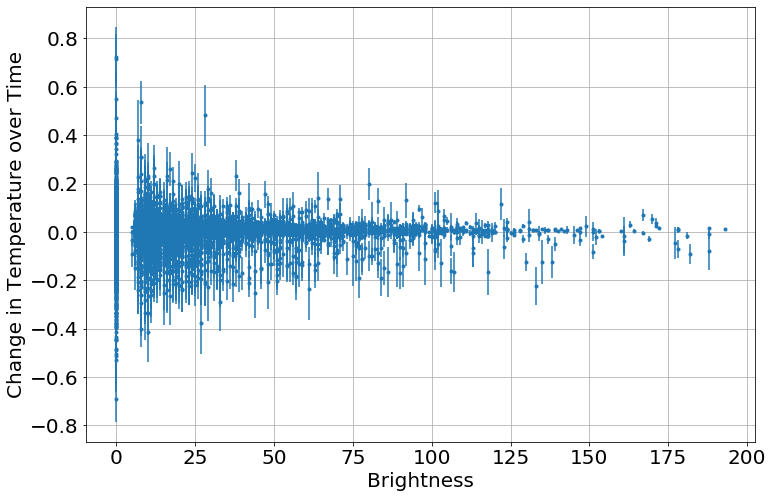

In [68]:
x=brightness
y=m
yerr=mσ
plt.xlabel('Brightness')
plt.ylabel('Change in Temperature over Time')
plt.errorbar(x,y,yerr,fmt='.')

This graph shows that change in temperature (in either direction) has a high variance at stations with a lower brightness, compared to stations with higher brightness.  This contradicts Crichton's primary claim that urban areas heat up more than rural areas, and because it is all of the data, it shows that Crichton did in fact cherry pick his data.  

# Conclusion

In conclusion, Crichton cherry picked his data, and his claim that urban areas heat up more than rural areas is proven false when tested on the entire dataset.  Although there is still a clear upward trend in temperature when regression is run on all stations in the world, it is not due to urban cities.